# Cognitive Data with XGBoost
Adapted from Predicting Heart Disease using ML (XGBoost):  
https://www.kaggle.com/code/adepvenugopal/predicting-heart-disease-using-ml-xgboost/notebook

Note: In order to use `SHAP`, the notebook needs be run under python 3.10.  
To do this:
- create a virtual environment using python3.10: `python3.10 -m venv venv`  
- activate the environment: `source venv/bin/activate`
- install the requirements: `pip install -r requirements.txt -U`
- run `jupyter` from enviroment: `./venv/bin/jupyter lab`

See also the NHANES example using SHAP: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from utils import make_machine_learning_df, feature_imp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve
from IPython.display import display
import shap

In [12]:
%matplotlib inline 
sns.set() # set seaborn styles, not sure I need to run %matplotlib inline 

---

## data prep
create datafarames for deomgraphics, cognitive functioning scrores, and perio info  
NHANES cognitive data downloaded from https://www.icpsr.umich.edu/web/about/cms/3625/

In [13]:
adjusted_df = make_machine_learning_df() # NB: the data is duplicated to reflect surview weights
len(adjusted_df)

8554

In [14]:
adjusted_df.head()

,female,age,low_global_re,pct_teeth_gt_3,pct_teeth_gt_4,pct_teeth_gt_5,pct_teeth_gt_6
SEQN,,,,,,,
62174,0,80,0.0,0.44,0.11,0.0,0.0
62174,0,80,0.0,0.44,0.11,0.0,0.0
62174,0,80,0.0,0.44,0.11,0.0,0.0
62174,0,80,0.0,0.44,0.11,0.0,0.0
62174,0,80,0.0,0.44,0.11,0.0,0.0


---

## scale/standardize data

In [15]:
# standarize train_df values
scaler = StandardScaler() # creates z-scores

# trainform data
standardize_cols = ['age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6']
scaled_data = scaler.fit_transform(adjusted_df[standardize_cols].to_numpy())

# put scaled data in dataframe
scaled_df = pds.DataFrame(scaled_data, columns=standardize_cols, index=adjusted_df.index)
scaled_df = pds.concat([adjusted_df[['female', 'low_global_re']], scaled_df], axis=1)

In [16]:
scaled_df.female.value_counts()

0    5388
1    3166
Name: female, dtype: int64

## split train/test datasets

In [17]:
X = scaled_df.drop('low_global_re', axis=1)
y = scaled_df['low_global_re']

In [19]:
# X.head()

In [20]:
scaled_df.female.value_counts()

0    5388
1    3166
Name: female, dtype: int64

In [21]:
# create test and train datasets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X,
        y,
        test_size=0.3, 
        random_state=42, 
        stratify=y
    )

---

## XGBoost classifier

### create classifier

In [22]:
xgb_classifier = xgb.XGBClassifier()

In [23]:
gbm_param_grid = {
    'n_estimators': range(1,20),
    'max_depth': range(1, 10),
    'learning_rate': [.1,.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1],
    'booster':["gbtree"],
     'min_child_weight': [0.001,0.003,0.01],
}

In [24]:
xgb_random = RandomizedSearchCV(
                param_distributions=gbm_param_grid, 
                estimator = xgb_classifier, 
                scoring = "accuracy", 
                verbose = 0, 
                n_iter = 100, 
                cv = 4
            )

In [25]:
xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=100,
                   param_distributions={'booster': ['gbtree'],
                                        'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1],
                                        'learning_rate': [0.1, 0.4, 0.45, 0.5,
                                                          0.55, 0.6],
                                        'max_depth': range(1, 10),
                                        'min_child_weight': [0.001, 0.003,
                                                             0.01],
                                        'n_estimators': range(1, 20)},
                   scoring='accuracy')

### run model

In [26]:
xgb_bp = xgb_random.best_params_
xgb_bp

{'n_estimators': 17,
 'min_child_weight': 0.003,
 'max_depth': 9,
 'learning_rate': 0.5,
 'colsample_bytree': 1,
 'booster': 'gbtree'}

In [27]:
xgb_model= \
    xgb.XGBClassifier(
        n_estimators=xgb_bp["n_estimators"],
        min_child_weight=xgb_bp["min_child_weight"],
        max_depth=xgb_bp["max_depth"],
        learning_rate=xgb_bp["learning_rate"],
        colsample_bytree=xgb_bp["colsample_bytree"],
        booster=xgb_bp["booster"]
)

In [28]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=0.003, missing=nan, monotone_constraints=None,
              n_estimators=17, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[::,1]

In [30]:
auc_score = round(roc_auc_score(y_test, y_proba), 5)
report = classification_report(y_test, y_pred, zero_division=0)

### plot results

In [31]:
print(f'AUC: {auc_score}')
print(report)

AUC: 0.99991
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2002
         1.0       1.00      0.98      0.99       565

    accuracy                           0.99      2567
   macro avg       1.00      0.99      0.99      2567
weighted avg       0.99      0.99      0.99      2567



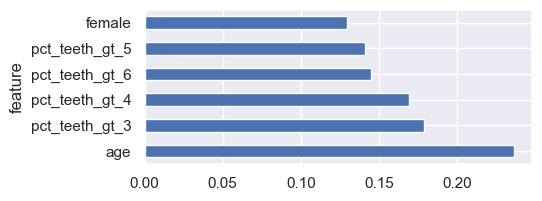

In [33]:
feature_imp(X_train, xgb_model).plot('feature', 'importance', 'barh', figsize=(5,2), legend=False)
plt.show()

---

## SHAP values  
https://github.com/slundberg/shap

In [34]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


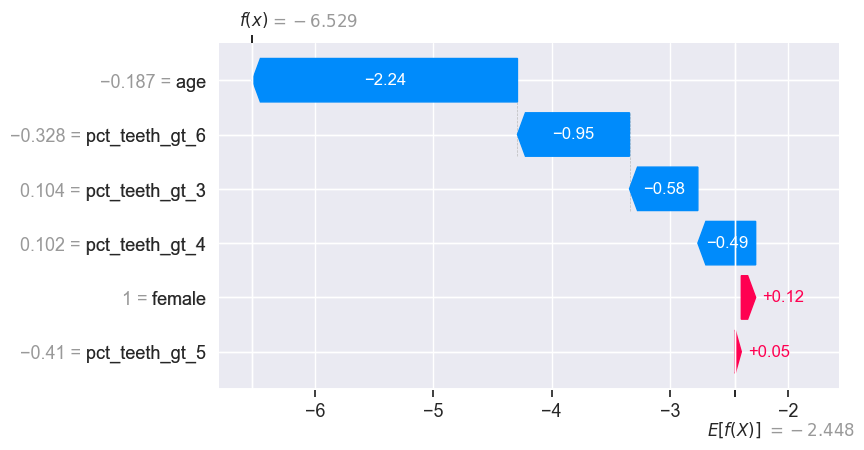

In [35]:
# visualize the first prediction's explanation
# documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
shap.plots.waterfall(shap_values[0])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.  
Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot.

In [36]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset 

In [37]:
# visualize all the training set predictions
shap.plots.force(shap_values)

In [38]:
X_train.columns # display column names

Index(['female', 'age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5',
       'pct_teeth_gt_6'],
      dtype='object')

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in `low_global_re` as `age` changes. 
Vertical dispersion at a single `age` value represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. In this case, it picks `pct_teeth_gt_4` (percentage of teeth with a CAL > 4mm) since that highlights that `age` has less impact for patients' `pct_teeth_gt_4`.

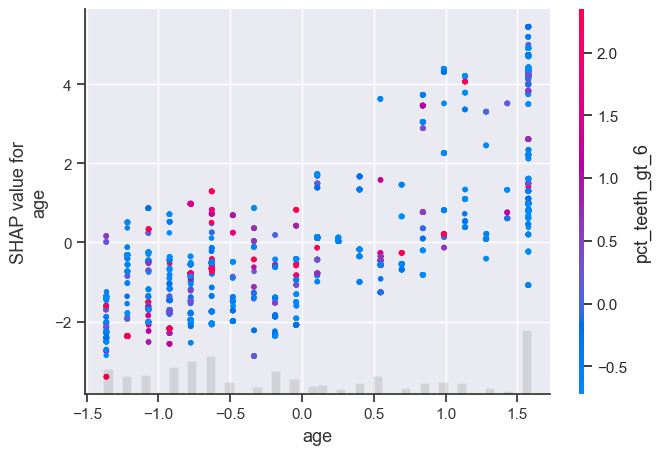

In [39]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"age"], color=shap_values)

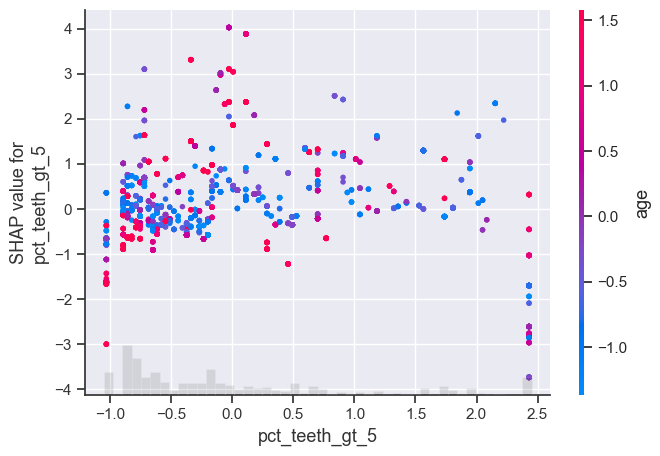

In [40]:
shap.plots.scatter(shap_values[:,"pct_teeth_gt_5"], color=shap_values)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


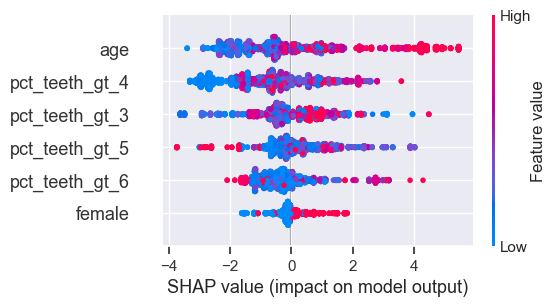

In [41]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, plot_size=(5, 3))

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).  
documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html

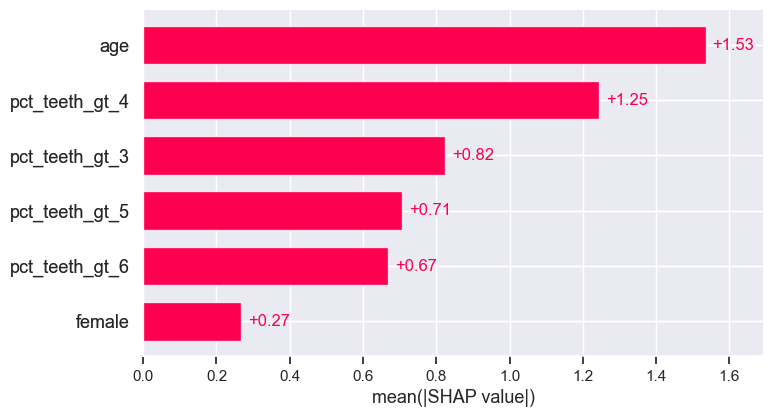

In [42]:
shap.plots.bar(shap_values)

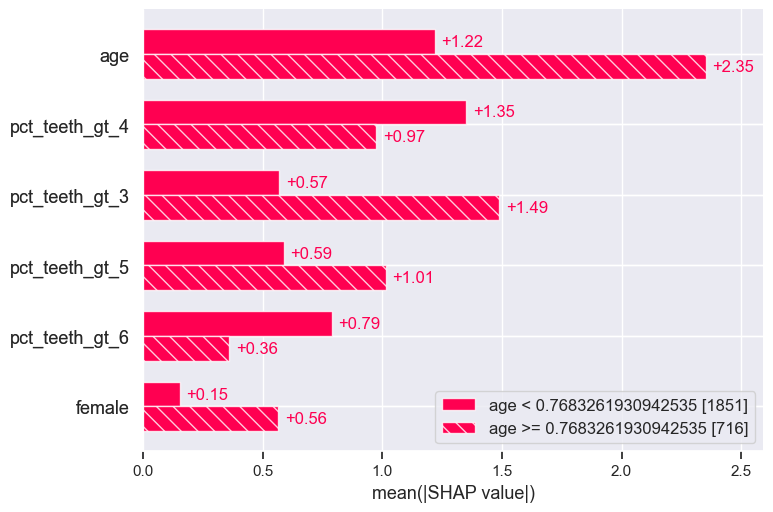

In [43]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


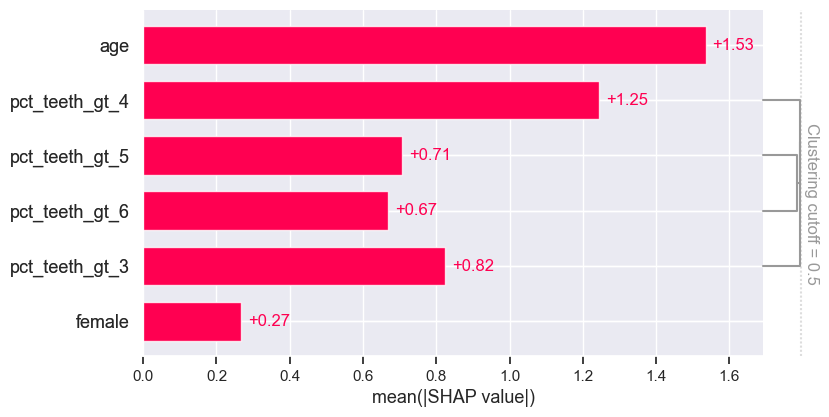

In [44]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(shap_values, clustering=clustering)

---

## SHAP Interaction Values
https://github.com/slundberg/shap#shap-interaction-values  

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with shap.TreeExplainer(model).shap_interaction_values(X). This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships.  
See also the NHANES example using SHAP: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

In [45]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features more time than SHAP values to compute
shap_interaction_values = shap.TreeExplainer(xgb_model).shap_interaction_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


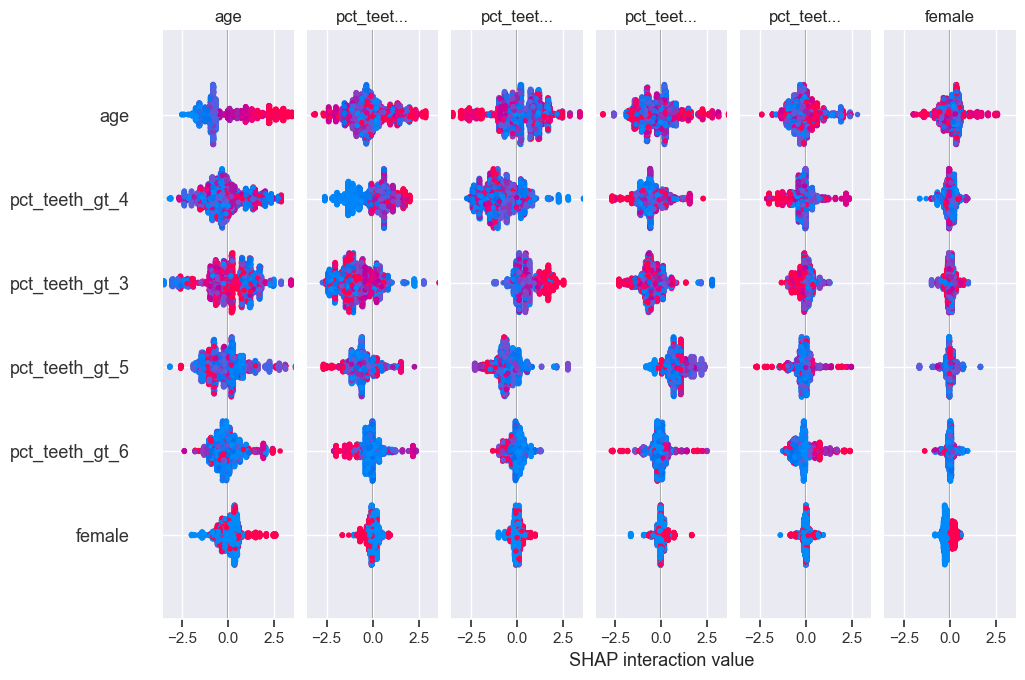

In [46]:
shap.summary_plot(shap_interaction_values, X_test)

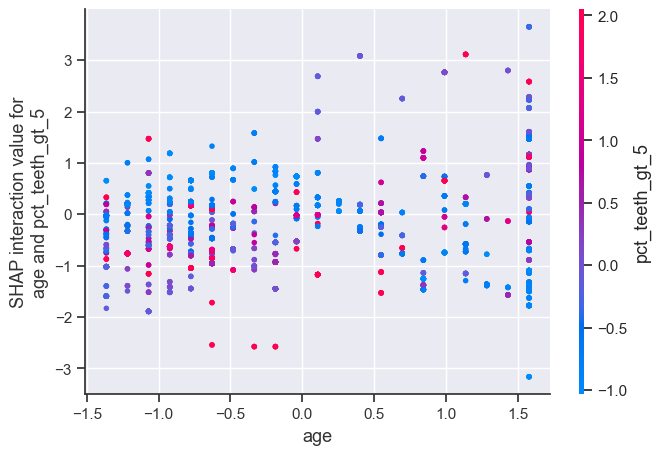

In [47]:
shap.dependence_plot(
    ("age", "pct_teeth_gt_5"),
    shap_interaction_values, X_test)